# Propp Wilson Algorithm for the Ferromagnetic Ising Model #

<b>Ferromagnetism</b> arises when a collection of atomic spins align such that their associated magnetic moments all point in the same direction, yielding a net magnetic moment which is macroscopic in the size. The simplest  theoretical description of ferromagnetism is called the <b>Ising Model</b>.

We implemented the <b>2D Ferromagnetic Ising Model</b> using Propp Wilson Algorithms in this project.

<b>Functions of the Ising Model:</b>

* `runIsing(t, state, U):`

* `updateState(t, state, U):`

* `calcEnergyDiff(i, j, state):`

* `InitialState(N):`

### Declaration of the libraries used in the program

In [2]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [3]:
using Distributions, LinearAlgebra
using Plots; pyplot(); default(legendfontsize = 15.0, linewidth = 2.0)
using Random

### Utility Functions

In [4]:
function InitialState(N)  # Generates an initial state with all values fixed to +1 and -1
    state = zeros(3, N, N)
    for i in 1:N
        for j in 1:N
            state[1, i, j] = 1
            state[2, i, j] = -1
        end
    end
    return state
end

InitialState (generic function with 1 method)

* Calculate the energy difference

In [5]:
function calcEnergyDiff(i, j, state)  # Calculate the energy at flipping the vertex at [i,j]
    m = size(state, 2)
    if i == 1
        top = 1
    else
        top = state[i - 1, j]
    end
    if i == m
        bottom = 1
    else
        bottom = state[i + 1, j]
    end
    if j == 1
        left = 1
    else
        left = state[i, j - 1]
    end
            
    if j == m
        right = 1
    else
        right = state[i, j + 1]
    end

    energy = 2 * state[i, j] * sum([top, bottom, left, right])  # Energy calculated by given formula
                
    return energy
end
    


calcEnergyDiff (generic function with 1 method)

* Update State for Ising Model

k = Boltzmann constant. We assume that k equals to 1.
<a href="https://www.codecogs.com/eqnedit.php?latex=\beta&space;=1/kT" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\beta&space;=1/kT" title="\beta =1/kT" /></a>


In [6]:
function updateState(t, state, U,T)
    B = 1 / T
    E = zeros(3)# Initialize Energy

    i = Int(U[2,Int(-t)])  # Picks a random vertex, the same each time the chain runs from 1
    j = Int(U[3,Int(-t)])
    
    for h in 1:3

        E[h] =  calcEnergyDiff(i, j, state[h,:,:])  # Find energy under randomly generated flip of each state space separately

        u = U[1,Int(-t)]
        if state[h, i, j] == 1
            u = 1 - u
        end
        
        if u < 0.5 * (1 - tanh(0.5 * B * E[h]))  # condition to accept change, random number is the same each time
            state[h, i, j] = -state[h, i, j]
            #n[h]=1
        else
            state[h, i, j] = state[h, i, j]
            #n[h]=0
        end
    end

    return state  # returns both states
end

updateState (generic function with 1 method)

### Ising Model Function

In [7]:
function runIsing(t, state, U, T)  # Runs chain from the designated starting time until time 0

    while t < 0
        state = updateState(t, state, U,T)
        t += 1
    end
    return state
end

runIsing (generic function with 1 method)

## Propp Wilson Algorithm

<b>Introduction to Propp Wilson Algorithm</b>

The propp-Wilson Algorithm solves two different problems
* s' is distributed exactly π (" perfect simulation ")
* The algorithm <b>stops</b> automatically

### Pseudocode of the algorithm:

<b>1. </b> Set 𝑚 = 1

<b>2. </b> For each 𝑠 ∈ 𝑆, simulate the Markov chain starting at time −𝑁𝑚 in state 𝑠 

and running up to time 0 using the update function 𝜙 with the sequence 𝑈−𝑁𝑚 +1,𝑈−𝑁𝑚 +2, … ,𝑈−1,𝑈0

<b>3. </b> If all 𝑘 chains end up in the same state s at time 0, output s and stop

<b>4. </b> Set 𝑚: = 𝑚 + 1 and go to step 2

<b>Note:</b> The same sequence 𝑈0,𝑈−1, … is used for all 𝑘 chains.


<b>Functions in Propp Wilson Algorithm</b>
* 1. runProppWilson(N,j):
* 2. genRandomness(N,M): 
* 3. genStartingTimes(j):

``genRandomness(N,M)``: generates a sequence of i.i.d. random numbers for Propp-Wilson Algorithm
````

U0,U1,U2...

````

In [8]:
function genRandomness(N, M)  # generate and store three sets of random numbers
    U = zeros(3, M)

    U[2,:] = rand(1:N, M) # Random numbners i
    U[3,:] = rand(1:N, M)  # Random numbners j
    for i in 1:M
        U[1,i] = rand()  # Random numbners U
    end
    return U
end

genRandomness (generic function with 1 method)

``genStartingTimes(j)``: to generate the starting times, the function generates the sequence of the positive numbers like (N1,N2...) = (1,2,4,8)

In [9]:
function genStartingTimes(j)  # Creates starting times, each one is double the previous
    M = zeros(j)
    M[2] = 1
    for x in 3:j
        M[x] = 2 * M[x - 1]
    end       
    return M
end

genStartingTimes (generic function with 1 method)


* Propp Wilson Algorithm call the Ising model to run chain from the designated starting time until time 0 after each magnetization
 

<b>Magnetization Formula</b> :


In [10]:
function runProppWilson(N,j,T)
    M = genStartingTimes(j)# negative integers (-1,-2,-4,-8)
    U = genRandomness(N, 1)# U1,U2,U3...
    state = InitialState(N)
    m=2
    while state[1,:,:] != state[2,:,:]  # Condition for termination: both state spaces are the same
        U = hcat(U,genRandomness(N, Int(M[m] - M[m-1]))) # Generates more random numbers when necessary
        
        magnetization = sum([sum(i) for i in state[1,:,:]])-sum([sum(i) for i in state[2,:,:]])
        
        #println("magnetization= ",magnetization, "round= ", m)
        state = runIsing(-Int(M[m]), state,U, T)
        m += 1  # If states are not the same, goes to the next starting time
        
    end
    return state[1,:,:]
end

runProppWilson (generic function with 1 method)

## Graph ##

* Main Program  and Visualisation of the Result
* This Graph function below call the ProppWilson Algorithm.


* Python code for simulation

In [14]:
#Pkg.build("PyCall")

  Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`


In [15]:
using PyCall

In [16]:
py"""
import random
import numpy as np
from numpy.random import rand
import matplotlib

import matplotlib.pyplot as plt
def Graph(state, T):
    S = state.shape[1]  # Takes the size of the matrix
    print("Plotting!")
    for i in range(S):
        for j in range(S):
            if state[i][j] == 1:  # Graphs a red + if the matrix entry is positive
                plt.scatter(j, S - 1 - i, c='r', marker=',', )#s=(150,))
            elif state[i][j] == -1:  # Graphs a blue minus is the matrix is negative
                plt.scatter(j, S - 1 - i, c='b', marker=',', )#s=(150,))
    plt.title("Sample, T=%d" % (T) )
    print("Done!")
    plt.show()
"""

In [17]:
function Graph(N, j, T)
    state = runProppWilson(N, j,T)
    py"Graph"(state,T)
end


Graph (generic function with 1 method)

* Show Results
Run the program with the parameter below.

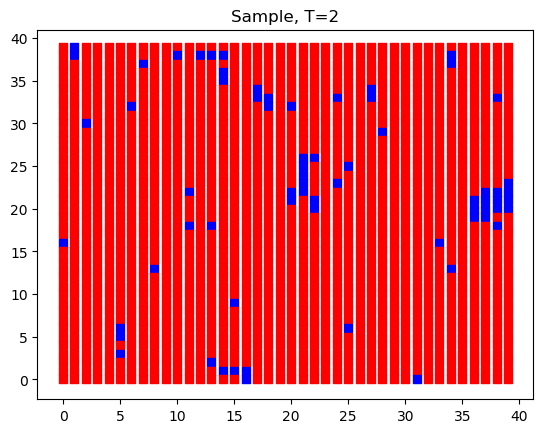

In [24]:
T = 2
Graph(40,50,T)

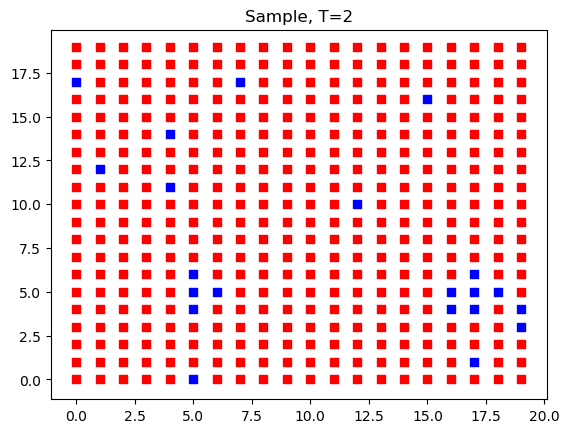

In [19]:
T = 2
Graph(20,30,T)